In [1]:
import pickle
import datetime
import pandas as pd
import numpy as np

# visulization
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score


import math


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

## Preprocessing Steps
First we load the backup datasets: weather dataset and the grass count dataset:

In [2]:
weather_dict = pickle.load(open('../weather_v2.pkl', "rb"))
grass_df = pd.read_csv('../preprocessing/melbourne_grass_preprocessed.csv')

In [3]:
weather_dict[1]

av_abl_ht  accum_prcp  av_lwsfcdown      av_mslp  av_qsair_scrn  \
2000-01-02    753.565    0.000156    293.490000  101769.3600       0.006113   
2000-01-03    882.295    0.011341    340.160000  101239.1200       0.007275   
2000-01-04    642.775    0.241001    354.760625  101026.8000       0.008047   
2000-01-05    850.585    0.021159    332.816250  101789.0000       0.006387   
2000-01-06    772.685    0.006436    339.945000  101948.0000       0.007227   
...               ...         ...           ...          ...            ...   
2021-11-15   1553.725    0.221102    330.088350  100551.4900       0.004862   
2021-11-16   1083.965    1.337187    318.977125  101237.7225       0.005006   
2021-11-17   1128.380    1.268011    320.695600  101640.2200       0.005241   
2021-11-18    979.960    0.101604    306.938000  101763.1200       0.004780   
2021-11-19   1204.930    0.001189    302.354999  102333.3500       0.004275   

            av_swsfcdown  av_temp_scrn  av_uwnd10m  av_vwnd10m  av_wndgust10m  \
2000-01-02    411.645000    289.752500    -0.85500     4.34000        8.49500   
2000-01-03    333.087500    294.993125     0.78000    -1.27000        8.58000   
2000-01-04    274.170000    289.227500     3.05000     4.83500       12.92000   
2000-01-05    309.916250    287.412500     3.65500     7.55500       16.02000   
2000-01-06    344.033125    289.284375     0.78500     5.96500       10.74500   
...                  ...           ...         ...         ...            ...   
2021-11-15    205.552563    284.695424     6.17675    -1.08775       14.75175   
2021-11-16    190.507200    283.395150     4.48575     0.85275       10.67300   
2021-11-17    250.670000    286.692800     1.83000    -0.44400        7.31600   
2021-11-18    233.195602    285.242799     3.24800     2.11200       10.89600   
2021-11-19    324.467502    285.771202    -0.51000     3.14200        8.37700   

            ...  thermal_time_1D  thermal_time_10D  thermal_time_30D  \
2000-01-02  ...         5.375000          6.375000          6.375000   
2000-01-03  ...         6.000000         13.000000         13.000000   
2000-01-04  ...         4.125000         17.375000         17.375000   
2000-01-05  ...         2.750000         20.250000         20.250000   
2000-01-06  ...         2.500000         23.000000         23.000000   
...         ...              ...               ...               ...   
2021-11-15  ...        12.093847        186.943945        580.543951   
2021-11-16  ...        10.062468        173.893874        561.493819   
2021-11-17  ...        17.999969        173.859443        563.559455   
2021-11-18  ...        11.300018        155.684588        561.284564   
2021-11-19  ...        16.650009        161.634463        568.634433   

            thermal_time_90D  thermal_time_180D  soil_mois_1D  soil_mois_10D  \
2000-01-02          6.375000           6.375000   2343.648438    2721.484375   
2000-01-03         13.000000          13.000000   2341.230469    4969.046875   
2000-01-04         17.375000          17.375000   2340.359375    7215.773438   
2000-01-05         20.250000          20.250000   2339.445312    9461.621094   
2000-01-06         23.000000          23.000000   2338.539062   11706.601562   
...                      ...                ...           ...            ...   
2021-11-15       1585.193548        2362.679663   1045.839682   11343.954672   
2021-11-16       1573.693480        2362.054488   1025.873758   11336.536873   
2021-11-17       1581.559089        2375.895118   1008.494997   11319.998743   
2021-11-18       1580.934207        2381.395312   1012.830002   11331.521254   
2021-11-19       1593.984241        2403.545352   1017.665000   11328.056264   

            soil_mois_30D  soil_mois_90D  soil_mois_180D  
2000-01-02    2721.484375    2721.484375     2721.484375  
2000-01-03    4969.046875    4969.046875     4969.046875  
2000-01-04    7215.773438    7215.773438     7215.773438  
2000-01-05    9461.621094   

In [4]:
grass_df

Count Date  grass_count
0      1991-10-01          0.0
1      1991-10-02          0.0
2      1991-10-03          0.0
3      1991-10-04          0.0
4      1991-10-05          0.0
...           ...          ...
10711  2021-01-27          1.0
10712  2021-01-28          7.0
10713  2021-01-29          2.0
10714  2021-01-30          0.0
10715  2021-01-31          0.0

[10716 rows x 2 columns]

In [5]:
grass_df['Count Date'] = grass_df['Count Date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))

In [6]:
weather_dict[1]['date'] = weather_dict[1].index
df = pd.merge(grass_df, weather_dict[1], left_on='Count Date', right_on='date', how='left').drop('Count Date', axis=1)

In [7]:
df

grass_count   av_abl_ht  accum_prcp  av_lwsfcdown        av_mslp  \
0              0.0         NaN         NaN           NaN            NaN   
1              0.0         NaN         NaN           NaN            NaN   
2              0.0         NaN         NaN           NaN            NaN   
3              0.0         NaN         NaN           NaN            NaN   
4              0.0         NaN         NaN           NaN            NaN   
...            ...         ...         ...           ...            ...   
10711          1.0  834.791667    0.075095    352.086666  100960.166667   
10712          7.0  963.125000    0.000219    335.512920  101483.541667   
10713          2.0  896.600000    0.484703    395.593999  101408.280000   
10714          0.0  632.791667    0.407535    395.608746  100911.333333   
10715          0.0  748.458333    0.001671    359.496667  101510.916667   

       av_qsair_scrn  av_swsfcdown  av_temp_scrn  av_uwnd10m  av_vwnd10m  ...  \
0                NaN           NaN           NaN         NaN         NaN  ...   
1                NaN           NaN           NaN         NaN         NaN  ...   
2                NaN           NaN           NaN         NaN         NaN  ...   
3                NaN           NaN           NaN         NaN         NaN  ...   
4                NaN           NaN           NaN         NaN         NaN  ...   
...              ...           ...           ...         ...         ...  ...   
10711       0.007849    130.549167    289.445415   -0.145833    4.887499  ...   
10712       0.007803    334.555417    293.186250   -2.487500    2.991666  ...   
10713       0.009936    132.476798    295.356401   -2.292000   -0.148000  ...   
10714       0.011993     86.142084    292.612085    0.550000   -1.445833  ...   
10715       0.008391    275.843329    291.180419    0.341666    3.920833  ...   

       thermal_time_10D  thermal_time_30D  thermal_time_90D  \
0                   NaN               NaN               NaN   
1                   NaN               NaN               NaN   
2                   NaN               NaN               NaN   
3                   NaN               NaN               NaN   
4                   NaN               NaN               NaN   
...                 ...               ...               ...   
10711         75.999756        184.374908        184.374908   
10712         76.049896        186.924896        186.924896   
10713         74.274933        185.274902        185.274902   
10714         71.924927        182.549927        182.549927   
10715         67.650024        185.149872        185.149872   

       thermal_time_180D  soil_mois_1D  soil_mois_10D  soil_mois_30D  \
0                    NaN           NaN            NaN            NaN   
1                    NaN           NaN            NaN            NaN   
2                    NaN           NaN            NaN            NaN   
3                    NaN           NaN            NaN            NaN   
4                    NaN           NaN            NaN            NaN   
...                  ...           ...            ...            ...   
10711         787.493103   7547.602417   76221.471649  229415.330170   
10712         789.674408   7535.679962   76149.324097  229251.895264   
10713         790.161865   7836.774933   76074.451599  229086.352783   
10714         789.127441   7542.737488   76027.771698  228949.192780   
10715         791.405579   7537.892426   76006.474243  228821.920197   

       soil_mois_90D  soil_mois_180D       date  
0                NaN             NaN        NaT  
1                NaN             NaN        NaT  
2                NaN             NaN        NaT  
3                NaN             NaN        NaT  
4                NaN             NaN        NaT  
...              ...             ...        ...  
10711  692386.868195   961095.985832 2021-01-27  
10712  692180.215698   967718.756729 2021-01-28  
10713  691967.418121   974334.436188 2021-01-29  
10714  6917

In [8]:
# check missing values
df.isna().values.sum()

# dual with missing values
df = df.dropna()

In [9]:
df

grass_count   av_abl_ht  accum_prcp  av_lwsfcdown        av_mslp  \
3015           0.0  753.565000    0.000156    293.490000  101769.360000   
3016           0.0  882.295000    0.011341    340.160000  101239.120000   
3017           0.0  642.775000    0.241001    354.760625  101026.800000   
3018           0.0  850.585000    0.021159    332.816250  101789.000000   
3019           0.0  772.685000    0.006436    339.945000  101948.000000   
...            ...         ...         ...           ...            ...   
10711          1.0  834.791667    0.075095    352.086666  100960.166667   
10712          7.0  963.125000    0.000219    335.512920  101483.541667   
10713          2.0  896.600000    0.484703    395.593999  101408.280000   
10714          0.0  632.791667    0.407535    395.608746  100911.333333   
10715          0.0  748.458333    0.001671    359.496667  101510.916667   

       av_qsair_scrn  av_swsfcdown  av_temp_scrn  av_uwnd10m  av_vwnd10m  ...  \
3015        0.006113    411.645000    289.752500   -0.855000    4.340000  ...   
3016        0.007275    333.087500    294.993125    0.780000   -1.270000  ...   
3017        0.008047    274.170000    289.227500    3.050000    4.835000  ...   
3018        0.006387    309.916250    287.412500    3.655000    7.555000  ...   
3019        0.007227    344.033125    289.284375    0.785000    5.965000  ...   
...              ...           ...           ...         ...         ...  ...   
10711       0.007849    130.549167    289.445415   -0.145833    4.887499  ...   
10712       0.007803    334.555417    293.186250   -2.487500    2.991666  ...   
10713       0.009936    132.476798    295.356401   -2.292000   -0.148000  ...   
10714       0.011993     86.142084    292.612085    0.550000   -1.445833  ...   
10715       0.008391    275.843329    291.180419    0.341666    3.920833  ...   

       thermal_time_10D  thermal_time_30D  thermal_time_90D  \
3015           6.375000          6.375000          6.375000   
3016          13.000000         13.000000         13.000000   
3017          17.375000         17.375000         17.375000   
3018          20.250000         20.250000         20.250000   
3019          23.000000         23.000000         23.000000   
...                 ...               ...               ...   
10711         75.999756        184.374908        184.374908   
10712         76.049896        186.924896        186.924896   
10713         74.274933        185.274902        185.274902   
10714         71.924927        182.549927        182.549927   
10715         67.650024        185.149872        185.149872   

       thermal_time_180D  soil_mois_1D  soil_mois_10D  soil_mois_30D  \
3015            6.375000   2343.648438    2721.484375    2721.484375   
3016           13.000000   2341.230469    4969.046875    4969.046875   
3017           17.375000   2340.359375    7215.773438    7215.773438   
3018           20.250000   2339.445312    9461.621094    9461.621094   
3019           23.000000   2338.539062   11706.601562   11706.601562   
...                  ...           ...            ...            ...   
10711         787.493103   7547.602417   76221.471649  229415.330170   
10712         789.674408   7535.679962   76149.324097  229251.895264   
10713         790.161865   7836.774933   76074.451599  229086.352783   
10714         789.127441   7542.737488   76027.771698  228949.192780   
10715         791.405579   7537.892426   76006.474243  228821.920197   

       soil_mois_90D  soil_mois_180D       date  
3015     2721.484375     2721.484375 2000-01-02  
3016     4969.046875     4969.046875 2000-01-03  
3017     7215.773438     7215.773438 2000-01-04  
3018     9461.621094     9461.621094 2000-01-05  
3019    11706.601562    11706.601562 2000-01-06  
...              ...             ...        ...  
10711  692386.868195   961095.985832 2021-01-27  
10712  692180.215698   967718.756729 2021-01-28  
10713  691967.418121   974334.436188 2021-01-29  
10714  6917

In [10]:
# sort the whole dataframe by date (in time order)
df = df.sort_values(by=['date'])

# add a new column "year" to count each year's data
df['year'] = df['date'].dt.to_period("Y").astype(str)

# for training
df['train'] = df['date'].dt.to_period("M").astype(str)

# add a new column "month" to count each year's data
# df['month'] = df['date'].dt.strftime('%m').astype(str)

# show the counts of each year
df['year'].value_counts(ascending = False)

2012    366
2004    366
2016    366
2008    366
2000    365
2019    365
2018    365
2017    365
2015    365
2014    365
2013    365
2011    365
2001    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2020    360
2021     31
Name: year, dtype: int64

In [11]:
df = df[df['year'] != '2021']

### 1) Plot of grass pollen count for each year
In this part, we will show the grass pollen count for each year in general.

In [12]:
group1 = df.groupby('year')
fig1 = go.Figure()
for group_name, single_df in group1:  
    # by year (continues)
    fig1.add_trace(go.Scatter(x=single_df['date'], y=single_df['grass_count'], name = group_name))
fig1.update_layout(height=600, width=1000)


### 2) Distribution of grass pollen count 
In this part, we can visualize the target variable: grass pollen count. We can see most of the pollen days are low between 0 to 10.

In [13]:
# plt.figure(figsize=(8, 6), dpi=80)
# sns.distplot(df['grass_count'],
#              color='#918BC3',
#              label="grass_count",
#              hist_kws={'alpha': .7},
#              kde_kws={'linewidth': 3})
# plt.grid(True)
# plt.title('Density Plot of grass count', fontsize=14)
# plt.legend()
# plt.show()

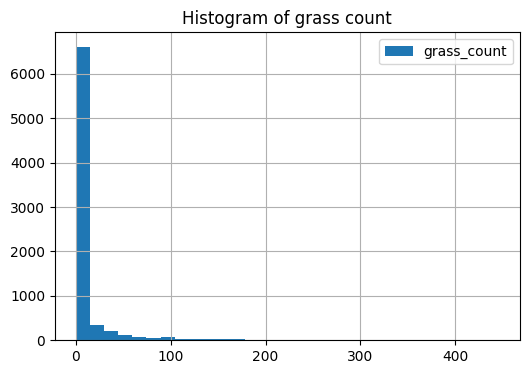

In [26]:
plt.figure(figsize=(6, 4))
# kernel density estimation (KDE) is the application of kernel smoothing for probability density estimation
plt.hist(df['grass_count'], label="grass_count", bins=30)
plt.grid(True)
plt.title('Histogram of grass count', fontsize=12)
plt.legend()

In [18]:
df.to_csv('backup_data_preprocessed.csv', index=False)

In [19]:
df

grass_count    av_abl_ht  accum_prcp  av_lwsfcdown        av_mslp  \
3015           0.0   753.565000    0.000156    293.490000  101769.360000   
3016           0.0   882.295000    0.011341    340.160000  101239.120000   
3017           0.0   642.775000    0.241001    354.760625  101026.800000   
3018           0.0   850.585000    0.021159    332.816250  101789.000000   
3019           0.0   772.685000    0.006436    339.945000  101948.000000   
...            ...          ...         ...           ...            ...   
10680        119.0  1261.250000    0.000679    336.648331  100953.083333   
10681         52.0  1430.958333    0.188170    373.324172  100712.875000   
10682          2.0  1519.916667    0.001351    339.529167  101467.833333   
10683          9.0   901.160000    0.000091    311.778802  101782.160000   
10684         14.0   808.920000    0.004603    353.954401  101928.720000   

       av_qsair_scrn  av_swsfcdown  av_temp_scrn  av_uwnd10m  av_vwnd10m  ...  \
3015        0.006113    411.645000    289.752500   -0.855000    4.340000  ...   
3016        0.007275    333.087500    294.993125    0.780000   -1.270000  ...   
3017        0.008047    274.170000    289.227500    3.050000    4.835000  ...   
3018        0.006387    309.916250    287.412500    3.655000    7.555000  ...   
3019        0.007227    344.033125    289.284375    0.785000    5.965000  ...   
...              ...           ...           ...         ...         ...  ...   
10680       0.006370    382.160006    297.887499    0.433333   -0.908333  ...   
10681       0.006539    132.561667    292.519165    1.533333    1.174999  ...   
10682       0.004866    224.656248    288.478748    0.158333    3.708333  ...   
10683       0.007105    372.794401    291.002400   -0.416000    3.292000  ...   
10684       0.008712    297.748395    291.171202    0.072000    4.372000  ...   

       thermal_time_90D  thermal_time_180D  soil_mois_1D  soil_mois_10D  \
3015           6.375000           6.375000   2343.648438    2721.484375   
3016          13.000000          13.000000   2341.230469    4969.046875   
3017          17.375000          17.375000   2340.359375    7215.773438   
3018          20.250000          20.250000   2339.445312    9461.621094   
3019          23.000000          23.000000   2338.539062   11706.601562   
...                 ...                ...           ...            ...   
10680        160.599976         677.124481   7703.592438   77705.041809   
10681        158.274963         679.274445   7701.629913   77707.999268   
10682        157.250061         679.508850   7698.877380   77387.521759   
10683        159.399963         683.230713   8008.187408   77700.604279   
10684        157.824890         686.483765   7999.360016   77683.759460   

       soil_mois_30D  soil_mois_90D  soil_mois_180D       date  year    train  
3015     2721.484375    2721.484375     2721.484375 2000-01-02  2000  2000-01  
3016     4969.046875    4969.046875     4969.046875 2000-01-03  2000  2000-01  
3017     7215.773438    7215.773438     7215.773438 2000-01-04  2000  2000-01  
3018     9461.621094    9461.621094     9461.621094 2000-01-05  2000  2000-01  
3019    11706.601562   11706.601562    11706.601562 2000-01-06  2000  2000-01  
...              ...            ...             ...        ...   ...      ...  
10680  232021.048706  671973.964569   754149.210911 2020-12-27  2020  2020-12  
10681  231986.591095  679675.594482   760968.803474 2020-12-28  2020  2020-12  
10682  231623.476013  687053.616882   767469.413036 2020-12-29  2020  2020-12  
10683  231889.883423  695061.804291   774604.499500 2020-12-30  2020  2020-12  
10684  231836.275970  695957.374298   781405.386192 2020-12-31  2020  2020-12  

[7664 rows x 175 columns]